In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Bidirectional, LSTM, Dense, Dropout
from keras.models import Model, Sequential
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import numpy as np

        

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.debugging.set_log_device_placement(False)

Num GPUs Available:  1


In [2]:
df = pd.read_parquet('../data/btcusd_preprcd_with_regimes.parquet')

df.dropna(inplace=True)

NameError: name 'pd' is not defined

In [ ]:
print(df.info())
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 292616 entries, 47 to 292662
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   open              292616 non-null  float64
 1   high              292616 non-null  float64
 2   low               292616 non-null  float64
 3   close             292616 non-null  float64
 4   BB_up_diff        292616 non-null  float64
 5   BB_down_diff      292616 non-null  float64
 6   OBV_Z             292616 non-null  float64
 7   MACD_Histogram    292616 non-null  float64
 8   RSI               292616 non-null  float64
 9   CCI               292616 non-null  float64
 10  predict_trend     292616 non-null  float64
 11  regime            292616 non-null  float64
 12  smoothed_regimes  292616 non-null  float64
dtypes: float64(13)
memory usage: 31.3 MB
None


open                0
high                0
low                 0
close               0
BB_up_diff          0
BB_down_diff        0
OBV_Z               0
MACD_Histogram      0
RSI                 0
CCI                 0
predict_trend       0
regime              0
smoothed_regimes    0
dtype: int64

In [ ]:
def preprocess_data(train_df):
    # Log-transform prices
    for col in ['open', 'high', 'low', 'close']:
        train_df[f'{col}_log_return'] = np.log(train_df[col] / train_df[col].shift(1))
    
    # Standard scaling for MACD and CCI
    std_cols = ['MACD_Histogram', 'CCI']
    std_scaler = StandardScaler().fit(train_df[std_cols])
    train_df[std_cols] = std_scaler.transform(train_df[std_cols])
    
    # MinMax for RSI (focus on 30–70 range)
    # train_df['RSI'] = np.clip(train_df['RSI'], 30, 70)
    # rsi_scaler = MinMaxScaler(feature_range=(0, 1)).fit(train_df[['RSI']])
    # train_df['RSI'] = rsi_scaler.transform(train_df[['RSI']])
    
    train_df.drop(columns=['open', 'high', 'low', 'close', 'smoothed_regimes', 'regime'], inplace=True)
    train_df.dropna(inplace=True)
    return train_df

In [ ]:
df = preprocess_data(df)
sc = StandardScaler()
df['predict_trend'] = sc.fit_transform(df[['predict_trend']])

In [ ]:
y = df['predict_trend']
x = df.drop(columns=['predict_trend'])

In [ ]:
df.head()

,BB_up_diff,BB_down_diff,OBV_Z,MACD_Histogram,RSI,CCI,predict_trend,open_log_return,high_log_return,low_log_return,close_log_return
48,1.986388,-15.504388,0.753203,0.014047,69.736842,0.977955,-0.014499,0.001996,0.002316,0.000000,0.003951
49,3.822828,-14.153828,0.217083,0.012037,68.033813,0.668334,-0.005894,0.003410,0.007619,0.001037,-0.001819
50,4.948274,-13.282274,0.017523,0.008423,67.505436,0.488886,0.005596,0.000200,-0.005340,0.000974,-0.000988
51,4.983098,-13.180098,0.068341,0.005735,60.794603,0.524980,0.014372,-0.003008,-0.001663,-0.003080,0.000587
52,4.526285,-13.324285,0.083305,0.004532,58.851298,0.708238,0.022194,-0.000124,-0.000370,0.000000,0.001281


In [ ]:
y = df['predict_trend']
x = df.drop(columns=['predict_trend'])
x_train = x[:int(len(x)*0.6)]
y_train = y[:int(len(x)*0.6)]
x_val = x[int(len(x)*0.6):int(len(x)*0.8)]
y_val = y[int(len(x)*0.6):int(len(x)*0.8)]
x_test = x[int(len(x)*0.8):]
y_test = y[int(len(x)*0.8):]

In [ ]:
x_train = np.nan_to_num(x_train, nan=0.0, posinf=0.0, neginf=0.0)
y_train = np.nan_to_num(y_train, nan=0.0, posinf=0.0, neginf=0.0)
x_val = np.nan_to_num(x_val, nan=0.0, posinf=0.0, neginf=0.0)
y_val = np.nan_to_num(y_val, nan=0.0, posinf=0.0, neginf=0.0)

In [ ]:
# from xgboost import XGBRegressor
# from sklearn.metrics import mean_squared_error
# import numpy as np

# xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=20, random_state=42)
# xgb_model.fit(x_train, y_train)
# y_pred = xgb_model.predict(x_val)
# mse = mean_squared_error(y_val, y_pred)
# rmse = np.sqrt(mse)
# print(mse, rmse)

In [ ]:
from keras.regularizers import l2

# Define model parameters
model = Sequential()
model.add(LSTM(24, activation='linear', input_shape=(x_train.shape[1], 1), return_sequences=False, kernel_regularizer=l2(0.1)))
# model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear'))
# Compile model
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_val, y_val))


Epoch 1/20


/opt/anaconda3/envs/Universal/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5487/5487 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 63.1103

2025-03-19 20:43:12.072869: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


5487/5487 ━━━━━━━━━━━━━━━━━━━━ 1309s 238ms/step - loss: 63.1008 - val_loss: 1.4619
Epoch 2/20
5487/5487 ━━━━━━━━━━━━━━━━━━━━ 397s 72ms/step - loss: 0.7907 - val_loss: 1.4117
Epoch 3/20
5487/5487 ━━━━━━━━━━━━━━━━━━━━ 414s 76ms/step - loss: 0.7355 - val_loss: 1.3388
Epoch 4/20
5487/5487 ━━━━━━━━━━━━━━━━━━━━ 425s 77ms/step - loss: 0.6578 - val_loss: 1.3148
Epoch 5/20
5487/5487 ━━━━━━━━━━━━━━━━━━━━ 435s 79ms/step - loss: 0.6434 - val_loss: 1.6173
Epoch 6/20
5487/5487 ━━━━━━━━━━━━━━━━━━━━ 445s 81ms/step - loss: 1.3840 - val_loss: 1.4059
Epoch 7/20
5487/5487 ━━━━━━━━━━━━━━━━━━━━ 449s 82ms/step - loss: 0.7432 - val_loss: 1.4630
Epoch 8/20
5487/5487 ━━━━━━━━━━━━━━━━━━━━ 449s 82ms/step - loss: 0.7207 - val_loss: 1.3314
Epoch 9/20
5487/5487 ━━━━━━━━━━━━━━━━━━━━ 453s 83ms/step - loss: 0.7350 - val_loss: 1.3147
Epoch 10/20
5487/5487 ━━━━━━━━━━━━━━━━━━━━ 456s 83ms/step - loss: 0.7058 - val_loss: 1.4018
Epoch 11/20
5487/5487 ━━━━━━━━━━━━━━━━━━━━ 493s 90ms/step - loss: 0.6899 - val_loss: 1.4075
Epoch

In [ ]:
# xgb_model.save('../models/trending_market_model.h5')

In [ ]:
from keras.metrics import MeanSquaredError

custom_objects = {'mse': MeanSquaredError()}

model_n = tf.keras.models.load_model('../models/trending_market_model.h5', custom_objects=custom_objects)

y_pred = model_n.predict(x_test)

218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step


In [ ]:
y_pred = sc.inverse_transform(np.array(y_pred).reshape(-1, 1))
y_test = sc.inverse_transform(np.array(y_test).reshape(-1, 1))

In [ ]:
threshold = 100
signals_pred = np.where(y_pred > threshold, 1, np.where(y_pred < -threshold, -1, 0)).astype(int)
signals_test = np.where(y_test > threshold, 1, np.where(y_test < -threshold, -1, 0)).astype(int)

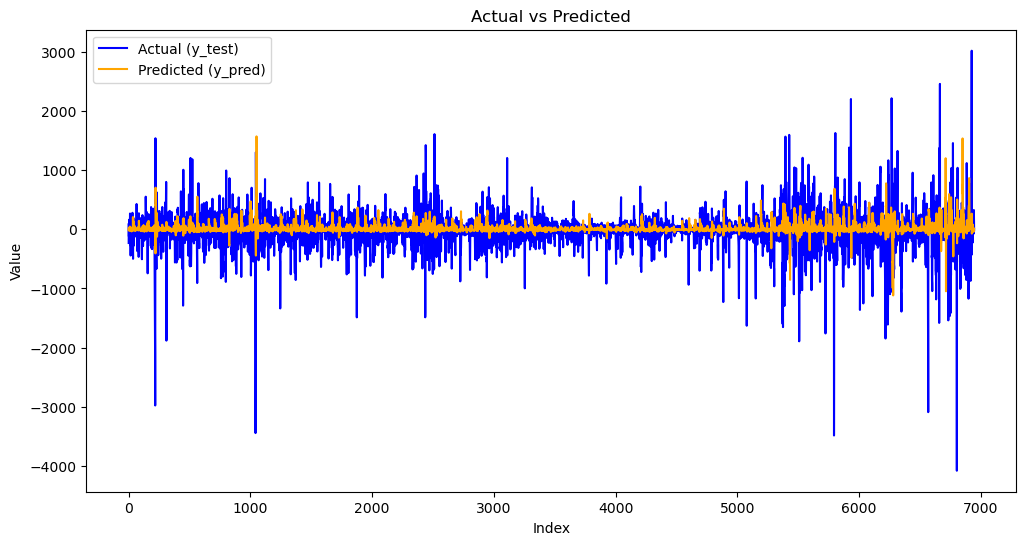

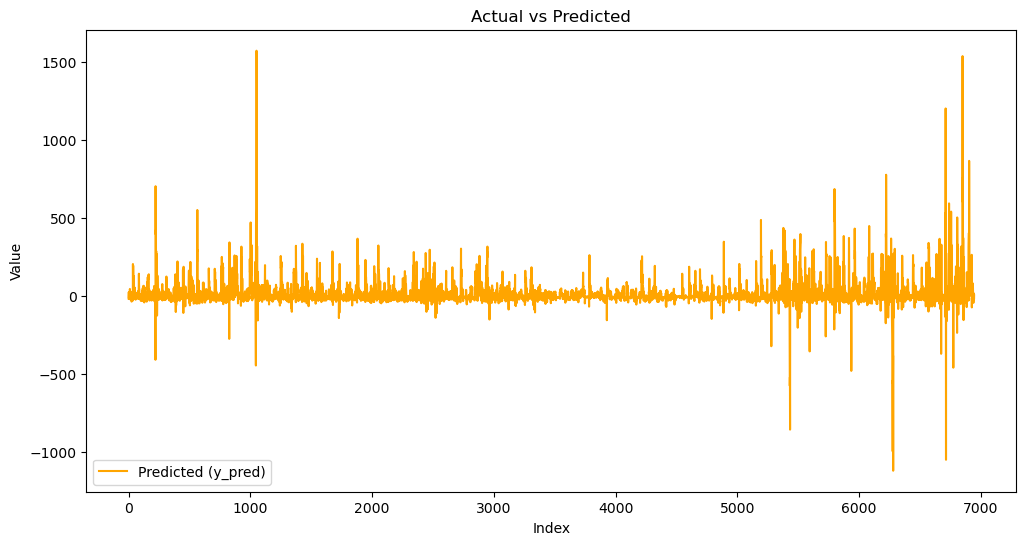

In [ ]:
data = pd.DataFrame({
    'Index': range(len(y_test)),
    'y_test': y_test.flatten(),  # Use .values to get NumPy array
    'y_pred': y_pred.flatten()   # Use .values to get NumPy array
})

# Plot the data
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Index', y='y_test', label='Actual (y_test)', color='blue')
sns.lineplot(data=data, x='Index', y='y_pred', label='Predicted (y_pred)', color='orange')

# Add labels and legend
plt.title('Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='Index', y='y_pred', label='Predicted (y_pred)', color='orange')

# Add labels and legend
plt.title('Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()